In [2]:
# Install necessary libraries
!pip install diffusers datasets transformers accelerate scipy ftfy

import datasets
import diffusers
import huggingface_hub
import torch
from diffusers import DDPMPipeline
from PIL import Image
from datasets import load_dataset
from torchvision import transforms
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from torch.nn import functional as F
from matplotlib import pyplot as plt

# Suppress warnings
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

# Load your own dataset
dataset = load_dataset("Rapidata/Other-Animals-10", split="train")  # Example dataset, replace with your dataset


# Create a subset of the first 1024 images
dataset = dataset.select(range(103))

# Check the length of the subset
print(f"Length of the subset: {len(dataset)}")

# Preprocessing
image_size = 64
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    examples["pixel_values"] = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return examples

# Apply the transform to the dataset
dataset.set_transform(transform)

# Create a custom dataset class to return tensors directly
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        return self.hf_dataset[idx]["pixel_values"]  # Return tensor directly

# Wrap the dataset in the custom class
tensor_dataset = TensorDataset(dataset)

# Create dataloader
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

# Model and scheduler
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 50  # Adjust as needed

for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch.to("cuda")  # Move batch to GPU
        # Get the actual batch size
        current_batch_size = clean_images.shape[0]

        # Create noise and timesteps with the correct batch size
        noise = torch.randn(clean_images.shape).to("cuda")
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (current_batch_size,), device="cuda").long()

        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}: Loss = {loss.item()}")

# Save the model
# Replace with your desired path
torch.save(model.state_dict(), "animal_diffusion_model.pth")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.2 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/103 [00:00<?, ? examples/s]

Length of the subset: 103
Epoch 0, Step 0: Loss = 1.111295223236084
Epoch 1, Step 0: Loss = 0.9620771408081055
Epoch 2, Step 0: Loss = 0.8543094992637634
Epoch 3, Step 0: Loss = 0.7781297564506531
Epoch 4, Step 0: Loss = 0.6561812162399292
Epoch 5, Step 0: Loss = 0.5548743605613708
Epoch 6, Step 0: Loss = 0.5729420185089111
Epoch 7, Step 0: Loss = 0.45706066489219666
Epoch 8, Step 0: Loss = 0.3730895519256592
Epoch 9, Step 0: Loss = 0.3834537863731384
Epoch 10, Step 0: Loss = 0.38286733627319336
Epoch 11, Step 0: Loss = 0.3544962406158447
Epoch 12, Step 0: Loss = 0.3181838393211365
Epoch 13, Step 0: Loss = 0.2642934322357178
Epoch 14, Step 0: Loss = 0.23183397948741913
Epoch 15, Step 0: Loss = 0.2604984641075134
Epoch 16, Step 0: Loss = 0.30050891637802124
Epoch 17, Step 0: Loss = 0.264976441860199
Epoch 18, Step 0: Loss = 0.17216180264949799
Epoch 19, Step 0: Loss = 0.17676591873168945
Epoch 20, Step 0: Loss = 0.2194986790418625
Epoch 21, Step 0: Loss = 0.24232296645641327
Epoch 22, S

Length of the dataset: 103


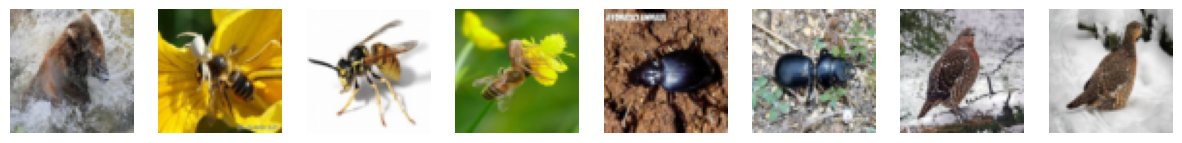

In [ ]:
# Check the length of the dataset
print(f"Length of the dataset: {len(dataset)}")

# Visualize some images from the dataset
import matplotlib.pyplot as plt

def visualize_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        # Get an image from the dataset
        image = dataset[i]["pixel_values"]  # Access the preprocessed tensor
        # Convert tensor to numpy and denormalize
        image = image.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C)
        image = (image * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        axes[i].imshow(image)
        axes[i].axis("off")
    plt.show()

# Visualize 5 images
visualize_images(dataset, num_images=8)

In [ ]:
import torch
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
import matplotlib.pyplot as plt
import os
from PIL import Image

# Load the trained model
model = UNet2DModel(
    sample_size=64,  # Match the image size used during training
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

# Load the saved model weights
model.load_state_dict(torch.load("animal_diffusion_model.pth"))
model.eval()  # Set the model to evaluation mode

# Set up the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Set output directory for generated images
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

# Function to generate and save one image at a time
def generate_and_save_image(i, num_images=1):
    # Start from random noise
    noise = torch.randn((1, 3, 256, 256)).to("cuda")  # Match input dimensions

    with torch.no_grad():  # Disable gradient computation
        for t in noise_scheduler.timesteps:
            # Predict the noise residual
            noise_pred = model(noise, t).sample

            # Compute the previous noisy sample x_t-1
            noise = noise_scheduler.step(noise_pred, t, noise).prev_sample

        # Convert to CPU and denormalize
        image = (noise.squeeze().cpu().numpy() * 0.5) + 0.5  # Denormalize
        image = (image * 255).astype("uint8").transpose(1, 2, 0)  # Convert to image format

        # Save the image to disk
        img_path = os.path.join(output_dir, f"animal_{i:02d}.png")
        Image.fromarray(image).save(img_path)
        print(f"Saved: {img_path}")

# Generate and save images one by one
num_images = 50
for i in range(num_images):
    generate_and_save_image(i, num_images)

# Zip the images (if you're running on a system where it's applicable)
!zip -r generated_images.zip generated_images
from google.colab import files
files.download("generated_images.zip")


<ipython-input-4-1a42d3388a78>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("animal_diffusion_model.pth"))


Saved: generated_images/animal_00.png
Saved: generated_images/animal_01.png
Saved: generated_images/animal_02.png
Saved: generated_images/animal_03.png
Saved: generated_images/animal_04.png
Saved: generated_images/animal_05.png
Saved: generated_images/animal_06.png
Saved: generated_images/animal_07.png
Saved: generated_images/animal_08.png
Saved: generated_images/animal_09.png
Saved: generated_images/animal_10.png
Saved: generated_images/animal_11.png
Saved: generated_images/animal_12.png
Saved: generated_images/animal_13.png
Saved: generated_images/animal_14.png
Saved: generated_images/animal_15.png
Saved: generated_images/animal_16.png
Saved: generated_images/animal_17.png
Saved: generated_images/animal_18.png
Saved: generated_images/animal_19.png
Saved: generated_images/animal_20.png
Saved: generated_images/animal_21.png
Saved: generated_images/animal_22.png
Saved: generated_images/animal_23.png
Saved: generated_images/animal_24.png
Saved: generated_images/animal_25.png
Saved: gener